Sources:
  - https://www.philschmid.de/fine-tuning-donut
  - https://github.com/clovaai/donut/blob/master/README.md
  - https://huggingface.co/docs/transformers/model_doc/donut

# Imports

In [66]:
# First execution of the runtime:
# !pip install datasets
# ! unzip /content/test_bw.zip

# Data

## Imports and configuration

In [67]:
import os
import json
from pathlib import Path
import shutil
from PIL import Image
from datasets import DatasetDict, Features, Dataset
import numpy as np

import random

import matplotlib.pyplot as plt


# define paths
base_path = Path("/content/")
label_path = base_path.joinpath("labels_500_bw.csv")
image_folder_path = base_path.joinpath("test_bw/")
extension = '.png'

labels_json = "labels.json"
labels_json_path = base_path.joinpath(labels_json)

## Labels  
Goal is to create a labels.json file that contains the information about the images including the OCR-text. This is necessary for the imagefolder feature of datasets.

The metadata.json should look at the end similar to the example below.  
`{"file_name": "0001.png", "text": "This is a golden retriever playing with a ball"}`   
`{"file_name": "0002.png", "text": "A german shepherd"}`

In [68]:

# define metadata list
labels_list = []

# Read csv and get labels
with open(label_path, "r") as label_csv:
  for no_line, line in enumerate(label_csv.readlines()):
    text = line.rstrip('\n').split('\t')
    # extract file name
    file_id = text[0]
    file_name = file_id + extension
    # sparse label
    label = text[1]

    # building json file
    sample = dict()
    sample['file_name'] = file_name
    sample['label'] = label
    labels_list.append(sample)

# Save data to a JSON file
with open(labels_json, "w") as file:
    json.dump(labels_list, file)


## Images
Goal is to create a dataset object similar to the one used in the tutorial and that was downloaded from hugging face directly

In [69]:
# Load JSON file
with open(labels_json_path, "r") as f:
    labels = json.load(f)

# Extract file names and labels
file_names = [sample["file_name"] for sample in labels]
text = [text["label"] for text in labels]

# Load images and convert to numpy arrays
images = []
for file_name in file_names:
    image_path = image_folder_path.joinpath(file_name)
    image = Image.open(image_path)
    # image = np.array(image)
    images.append(image)

# Define dataset features
features = Features({
    "image": images,
    "label": text,
    })

# Create a DatasetDict object
dataset = Dataset.from_dict(features)

In [70]:
def show_random_sample(dataset):
  """
  Function to display a random sample of the dataset: plot the image and its label
  """
  random_sample = random.randint(0, len(dataset))
  print(f"Random sample is {random_sample}")
  print(f"OCR text is: {dataset[random_sample]['label']}")

  plt.imshow(dataset[random_sample]['image'], cmap='gray')
  plt.show()

Dataset has 500 samples
Dataset features are: {'image': Image(decode=True, id=None), 'label': Value(dtype='string', id=None)}
Random sample is 69
OCR text is: prevent civil war , it was clear that new dangers


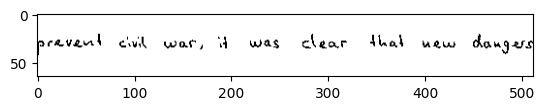

In [71]:
# Print dataset information
print(f"Dataset has {len(dataset)} samples")
print(f"Dataset features are: {dataset.features }")

# Display a random sample from the dataset
show_random_sample(dataset)





## Splitting ??

## Preprocessing of the data to feed model

Donut is a sequence-to-sequence model with a vision encoder and text decoder. When fine-tuning the model we want it to generate the "text" based on the image we pass it. Similar to NLP tasks, we have to tokenize and preprocess the text. Before we can tokenize the text, we need to transform the JSON string into a Donut compatible document.


In [72]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    # text = json.loads(sample["text"])

    text = sample['label']
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "label": d_doc}

proc_dataset = dataset.map(preprocess_documents_for_donut)

# print(f"Sample: {proc_dataset[45]['label']}")
# print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Random sample is 193
OCR text is: <s>and fishing gear leads to an overall</s>


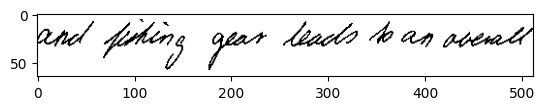

In [73]:
# Print a random sample from the dataset
show_random_sample(proc_dataset)
